# Requirements

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import kagglehub
import os

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [7]:
from functools import partial

# Maternal Health Risk Data

In [8]:
path = kagglehub.dataset_download("csafrit2/maternal-health-risk-data")
print(os.listdir(path))

['Maternal Health Risk Data Set.csv']


In [9]:
file_path = os.path.join(path, 'Maternal Health Risk Data Set.csv')

In [10]:
data = pd.read_csv(file_path)
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [11]:
data.RiskLevel.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [12]:
data.RiskLevel = data.RiskLevel.str.lower().str.replace(' ', '_')

In [13]:
data.RiskLevel.unique()

array(['high_risk', 'low_risk', 'mid_risk'], dtype=object)

In [14]:
data.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [15]:
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [16]:
df = data
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high_risk
1,35,140,90,13.0,98.0,70,high_risk
2,29,90,70,8.0,100.0,80,high_risk
3,30,140,85,7.0,98.0,70,high_risk
4,35,120,60,6.1,98.0,76,low_risk


# Setting up the validation framework

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = df_train.RiskLevel.values
y_val = df_val.RiskLevel.values
y_test = df_test.RiskLevel.values

del df_train['RiskLevel']
del df_val['RiskLevel']
del df_test['RiskLevel']

In [20]:
len(df_train), len(df_val), len(df_test)

(608, 203, 203)

# EDA

In [21]:
from IPython.display import display

In [22]:
df_full_train = df_full_train.reset_index(drop=True)

In [23]:
predictors = []

for c in df_full_train.columns:
    if c != "RiskLevel":
        predictors.append(c)

predictors

['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

# Distributions

In [24]:
df_long = df.melt(id_vars = "RiskLevel", value_vars= predictors)

displot = partial(sns.displot, 
                  data=df_long, kind='hist', 
                  x='value', col='variable', 
                  col_wrap=3, common_bins=False, 
                  facet_kws={'sharex': False, 'sharey': False})

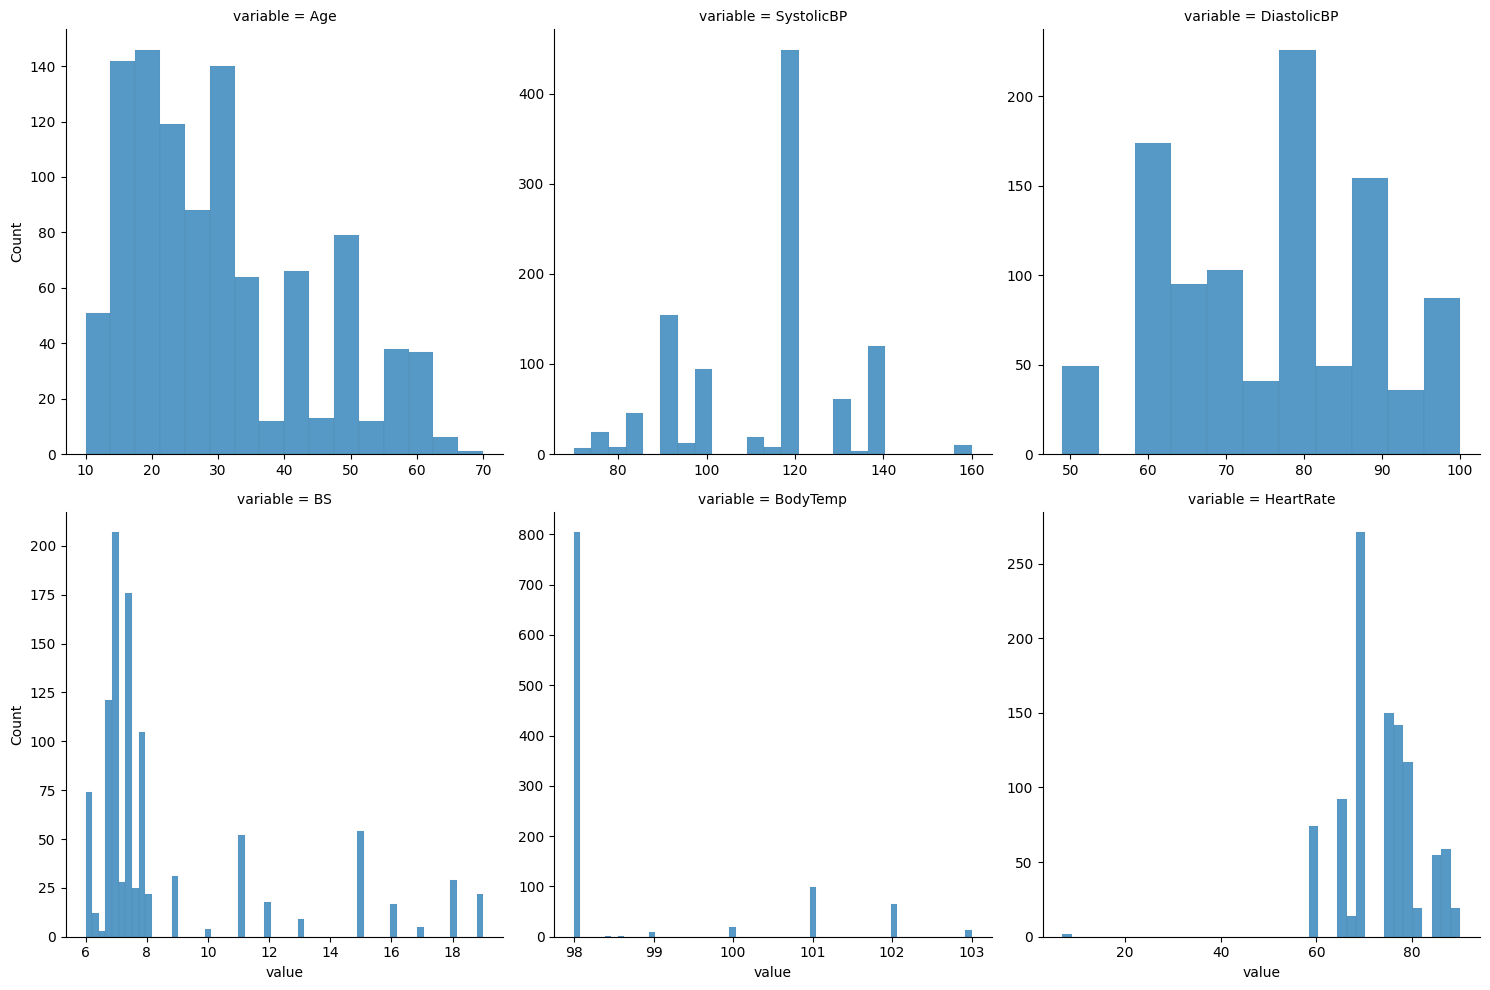

In [25]:
displot()
plt.show()

### Visualisation of importance of each variable

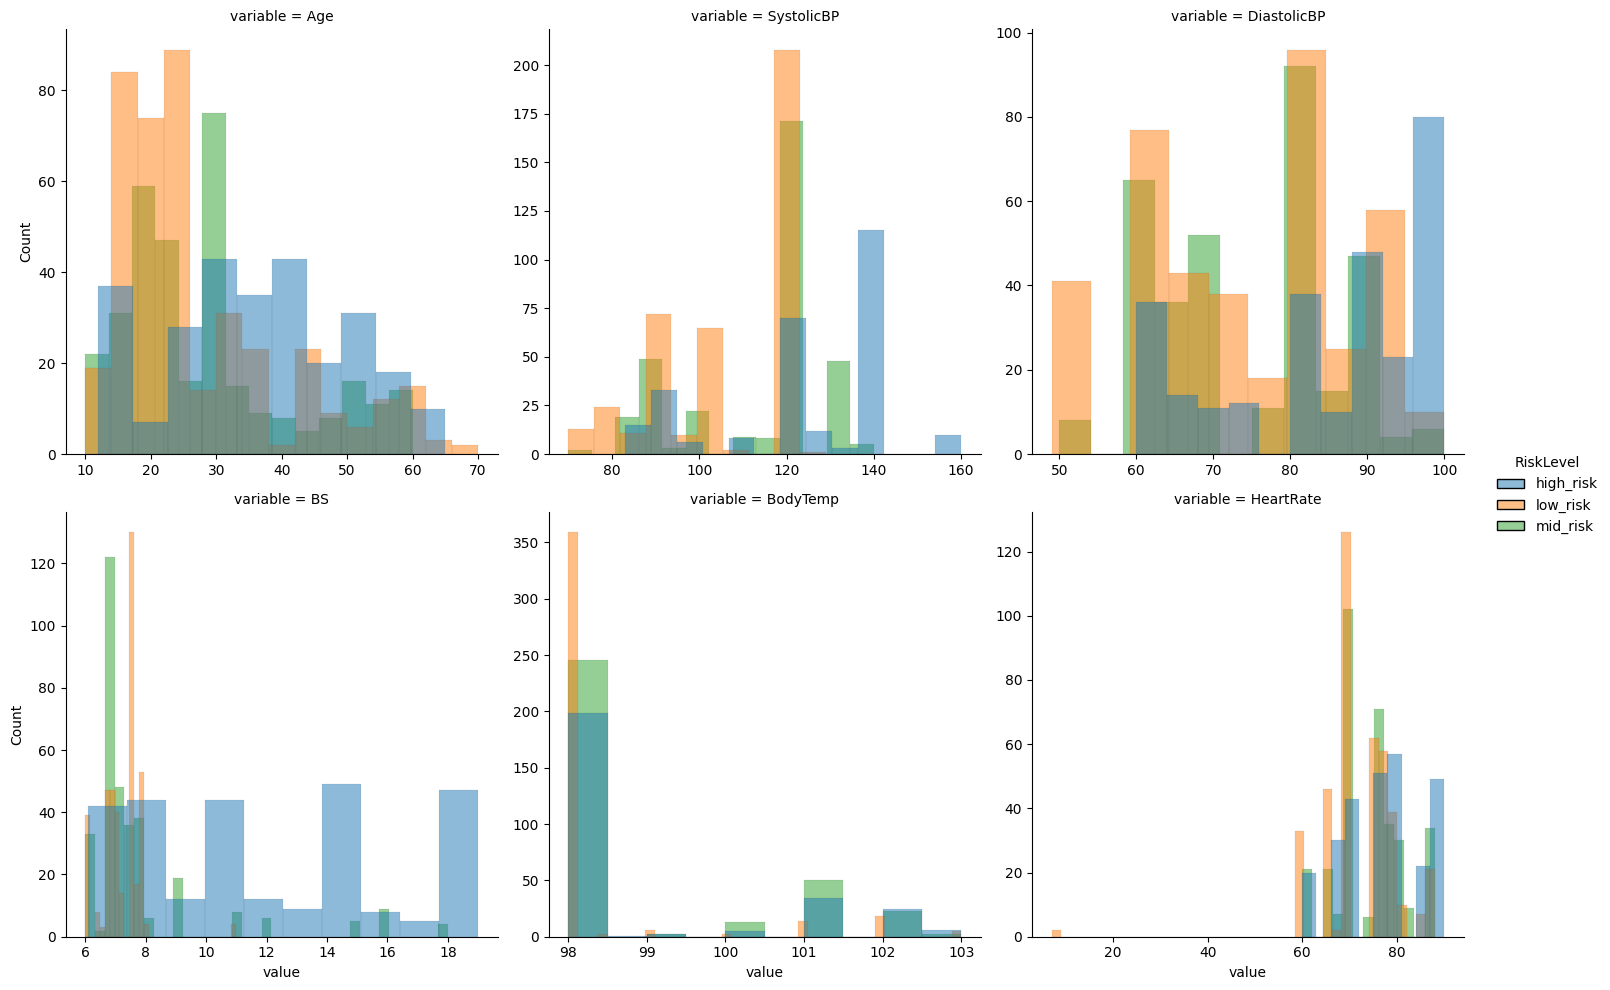

In [26]:
displot(hue='RiskLevel', alpha=0.5)
plt.show()

It seems that BS is the most important value (only low values are associated with low risk), while body temperature is not exoectd to be important because it shows equal distributions of risks

# Model selection

## One-hot encoding

In [27]:
dv = DictVectorizer(sparse=False)

In [28]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Logistic regression

In [29]:
model_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        solver="lbfgs",
        max_iter=3000,
        random_state=1
    ))
]) # lbfgs solves multiclass classification

In [30]:
model_log.fit(X_train, y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [44]:
y_pred_log = model_log.predict(X_val)

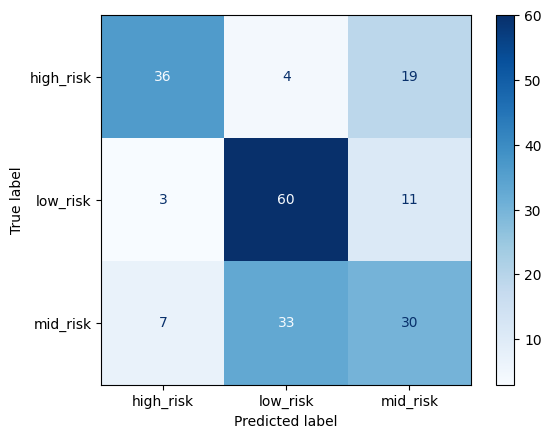

In [55]:
cm = confusion_matrix(y_val, y_pred_log, labels=model_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot(cmap='Blues')

In [48]:
f1_per_class = f1_score(y_val, y_pred_log, average=None)
print(f1_per_class)

[0.68571429 0.70175439 0.46153846]


In [49]:
labels = np.unique(y_val)

In [50]:
for label, f1 in zip(labels, f1_per_class):
    print(f"Class {label}: F1 = {f1:.3f}")

Class high_risk: F1 = 0.686
Class low_risk: F1 = 0.702
Class mid_risk: F1 = 0.462


**Result:** Mid risk is poorly predicted by regression model. The other classes are predicted more or less fine. Mid risk is cunfused with low risk.

## Decision tree
Tuning max depth and min samples leaf

In [47]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [59]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 40, 50, 100, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    f1_weighted = f1_score(y_val, y_pred, average="weighted")
    
    print('%4s -> %.3f' % (depth, f1_weighted))

   1 -> 0.447
   2 -> 0.486
   3 -> 0.670
   4 -> 0.691
   5 -> 0.710
   6 -> 0.679
   7 -> 0.761
   8 -> 0.760
   9 -> 0.784
  10 -> 0.795
  15 -> 0.808
  20 -> 0.819
  40 -> 0.804
  50 -> 0.818
 100 -> 0.818
None -> 0.814


**max_depth** = 50 - the best option

In [61]:
scores = []

for depth in [50, 60, 70, 80]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        f1_weighted = f1_score(y_val, y_pred, average="weighted")
        
        scores.append((depth, s, f1_weighted))

In [62]:
columns = ['max_depth', 'min_samples_leaf', 'f1_weighted']
df_scores = pd.DataFrame(scores, columns=columns)

In [63]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['f1_weighted'])
df_scores_pivot.round(3)

f1_weighted                     
max_depth                 50     60     70     80
min_samples_leaf                                 
1                      0.799  0.804  0.813  0.828
5                      0.782  0.797  0.806  0.806
10                     0.740  0.724  0.724  0.724
15                     0.668  0.668  0.668  0.668
20                     0.648  0.648  0.648  0.648
50                     0.610  0.610  0.610  0.610
100                    0.575  0.575  0.575  0.575
200                    0.426  0.426  0.426  0.426

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

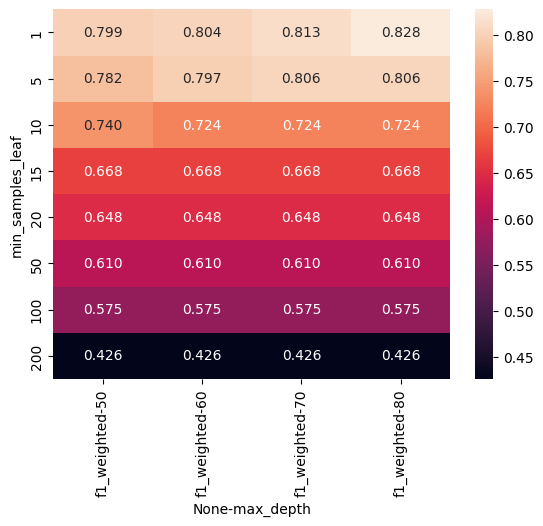

In [64]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [65]:
dt_best = DecisionTreeClassifier(max_depth=80, min_samples_leaf=1)
dt_best.fit(X_train, y_train)
    
y_pred_dt_best = dt_best.predict(X_val)

In [67]:
f1_classes_dt_best = f1_score(y_val, y_pred_dt_best, average=None)

In [69]:
for label, f1 in zip(labels, f1_classes_dt_best):
    print(f"Class {label}: F1 = {f1:.3f}")

Class high_risk: F1 = 0.877
Class low_risk: F1 = 0.759
Class mid_risk: F1 = 0.776


**Results:** all the classes are predicted much better. The most important class (high risk) is predicted with a very good F1 score - 0.88

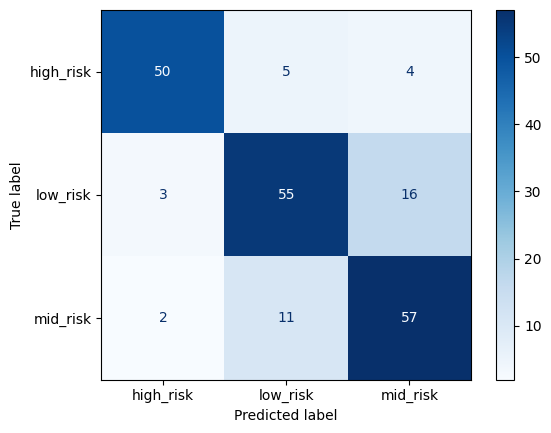

In [92]:
cm = confusion_matrix(y_val, y_pred_dt_best, labels=model_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot(cmap='Blues')

## Random forest

In [72]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    f1_weighted = f1_score(y_val, y_pred, average="weighted")
    
    scores.append((n, f1_weighted))

In [73]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'f1_weighted'])

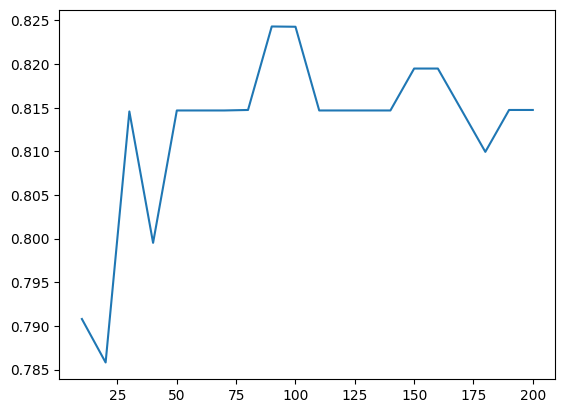

In [74]:
plt.plot(df_scores.n_estimators, df_scores.f1_weighted)

In [76]:
scores = []

for n in range(80, 120, 5):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    f1_weighted = f1_score(y_val, y_pred, average="weighted")
    
    scores.append((n, f1_weighted))

In [77]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'f1_weighted'])

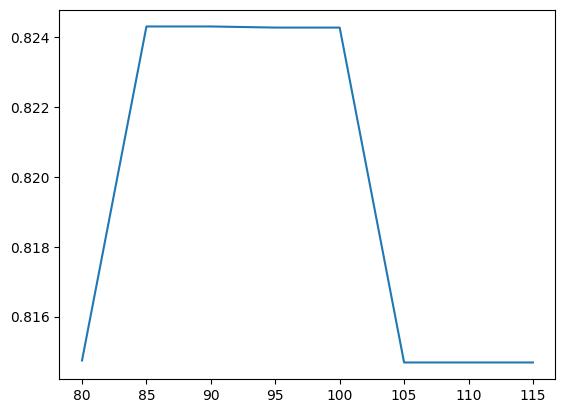

In [78]:
plt.plot(df_scores.n_estimators, df_scores.f1_weighted)

The best n_estimators: 90 - 100

In [85]:
scores = []

for d in [5, 10, 15, 20]:
    for n in range(85, 100, 5):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        f1_weighted = f1_score(y_val, y_pred, average="weighted")

        scores.append((d, n, f1_weighted))

In [86]:
columns = ['max_depth','n_estimators', 'f1_weighted']
df_scores = pd.DataFrame(scores, columns=columns)

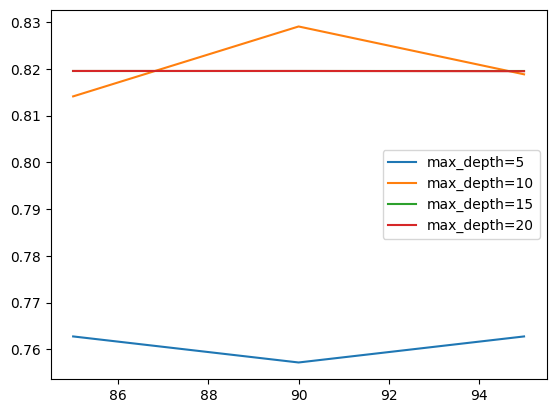

In [87]:
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.f1_weighted,
             label='max_depth=%d' % d)

plt.legend()

The best combination: max_depth = 10; n_estimators = 90

In [88]:
rf_best = RandomForestClassifier(n_estimators=90, max_depth=10, random_state=1)
rf_best.fit(X_train, y_train)

y_pred_rf = rf_best.predict(X_val)

In [89]:
f1_classes_rf = f1_score(y_val, y_pred_rf, average=None)

In [90]:
for label, f1 in zip(labels, f1_classes_rf):
    print(f"Class {label}: F1 = {f1:.3f}")

Class high_risk: F1 = 0.893
Class low_risk: F1 = 0.808
Class mid_risk: F1 = 0.797


**Results:** all the classes are predicted better. The most important class (high risk) is predicted with a great F1 score - 0.9

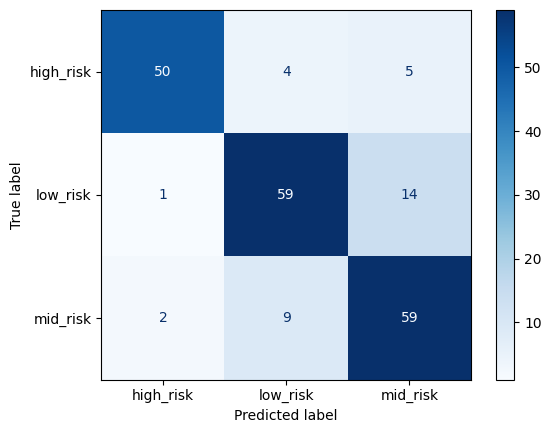

In [91]:
cm = confusion_matrix(y_val, y_pred_rf, labels=model_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot(cmap='Blues')

**Conclusion:** the best model is a random forest with 90 estimators and max depth = 10.

# Train the selected model

In [93]:
dv = DictVectorizer(sparse=False)

In [94]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

y_full_train = df_full_train.RiskLevel.values
y_test = df_test.RiskLevel.values

del df_full_train['RiskLevel']
del df_test['RiskLevel']

In [95]:
full_train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [97]:
rf_full = RandomForestClassifier(n_estimators=90,
                                max_depth=10,
                                random_state=1)
rf_full.fit(X_full_train, y_full_train)

,n_estimators,90
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [98]:
y_pred_full = rf_full.predict(X_test)
f1_classes_full = f1_score(y_test, y_pred_full, average=None)

In [99]:
for label, f1 in zip(labels, f1_classes_full):
    print(f"Class {label}: F1 = {f1:.3f}")

Class high_risk: F1 = 0.927
Class low_risk: F1 = 0.828
Class mid_risk: F1 = 0.746


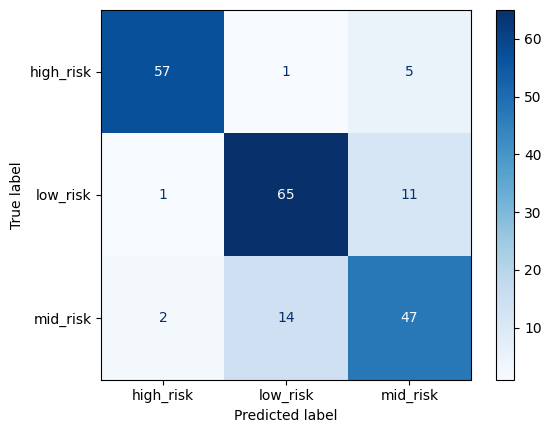

In [101]:
cm = confusion_matrix(y_test, y_pred_full, labels=model_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot(cmap='Blues')

# Predictions

In [105]:
person = test_dict[-1]

In [103]:
y_test[-1]

'high_risk'

In [106]:
X_person = pd.DataFrame([person])

In [109]:
pred = rf_full.predict(X_person)
type(pred[0])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


str

# Document for manual testing

In [110]:
import json

In [111]:
with open("test.txt", "w") as f:
    for d in test_dict:
        json_str = json.dumps(d, indent=4)
        f.write(json_str + "\n\n") 